## IST557 Midterm ##
author: Andrew Sugarman

#### References:
1. https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
2. https://www.cs.toronto.edu/~duvenaud/cookbook/ 
3. https://modelassist.epixanalytics.com/space/EA/26575606/A+stock+or+share+price,+or+interest+rate,+modeled+over+time
4. https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py
5. https://faridjb.github.io/Time-Series-Exploration/chapters/chapter_05.html

https://www.youtube.com/watch?v=UBDgSHPxVME


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 
df = pd.read_csv("./midterm_data/data_train_midterm_problem1.csv")
df['log_stock_price'] = np.log(df['stock_price'])
df['raw_change'] = df['stock_price'].diff()
df['log_change'] = df['log_stock_price'].diff()
df.head()

,date,stock_price,log_stock_price,raw_change,log_change
0,2011-01-02,28.072510,3.334791,NaN,NaN
1,2011-01-09,27.341080,3.308390,-0.731430,-0.026400
2,2011-01-16,28.636974,3.354699,1.295894,0.046308
3,2011-01-23,29.137842,3.372038,0.500868,0.017339
4,2011-01-30,29.233253,3.375307,0.095411,0.003269


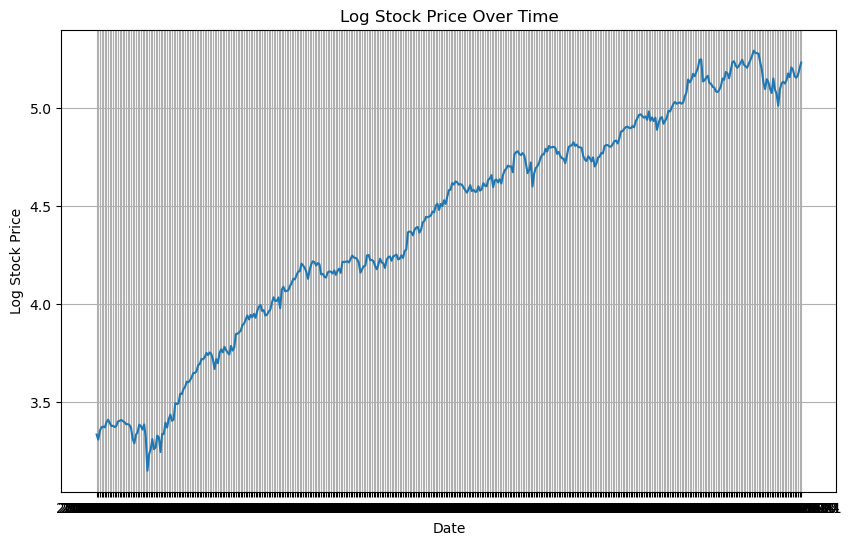

In [39]:
# plotting options
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['log_stock_price'])
plt.title('Log Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Stock Price')
plt.grid(True)
plt.show()

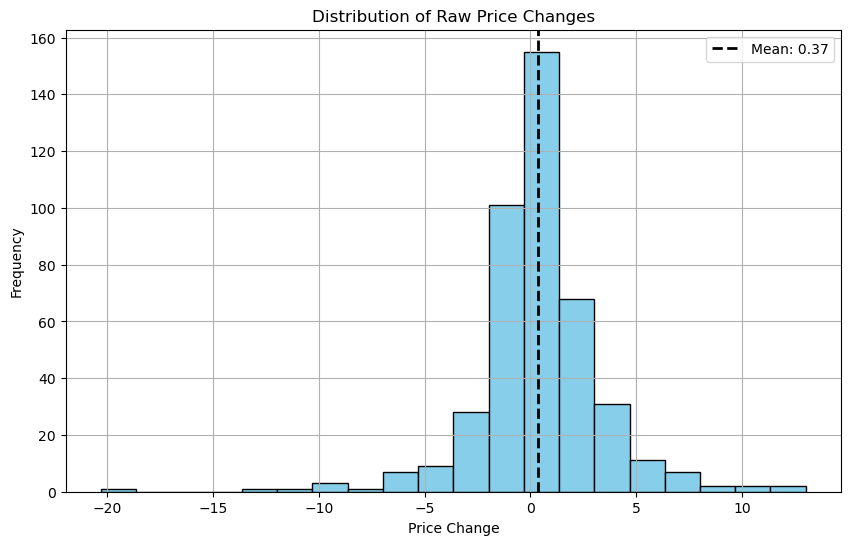

In [40]:
plt.figure(figsize=(10, 6))
plt.hist(df['raw_change'].dropna(), bins=20, edgecolor='black', color='skyblue')
mean_change = df['raw_change'].mean()
plt.axvline(mean_change, color='black', linestyle='--', linewidth=2, label=f'Mean: {mean_change:.2f}')
plt.title('Distribution of Raw Price Changes')
plt.xlabel('Price Change')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

datetime64[ns]


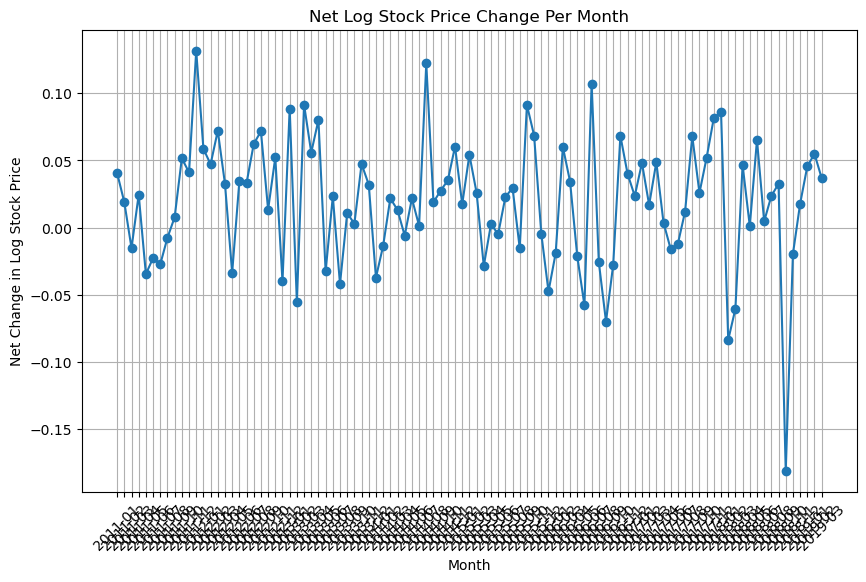

In [41]:
# plot average stock price for each month
# calculate net change in stock price per month 
df['date'] = pd.to_datetime(df['date'])
print(df['date'].dtype)
df['year_month'] = df['date'].dt.to_period('M')
month_means = df.groupby('year_month')['stock_price'].mean().reset_index()
month_changes = df.groupby('year_month')['log_change'].sum().reset_index()
#
plt.figure(figsize=(10, 6))
plt.plot(month_changes['year_month'].astype(str), month_changes['log_change'], marker='o')
plt.title('Net Log Stock Price Change Per Month')
plt.xlabel('Month')
plt.ylabel('Net Change in Log Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
 # plt.show()

### Problem 1a

- By plotting the distribution of change in log stock price we are able to look at how stable the price typically is from day to day, which may become important in feature selection and model parameter tuning. It is of interest to my model whether there are many drastic changes or mostly gradual changes accompanied by the occasional spike or dip. According to the histogram and corroborated by the line plot, it appears that changes in the log stock price are gradual and linear, but become more volatile as time increases. 
- The mean change in raw stock price (between sampled points, which are not every day but every week) is 0.37, indicating that stock price on average increases (since the mean value is positive) and does so at a slow rate (<1)

In summary, the data has an upward trend that generally follows a linear pattern with mixed random variability in some areas. The end of the time series appears to be more variable than the majority of the curve. These observations are informative as we move on to fit a gaussian process regression model, given that they may affect our choice in Kernel function. 

In [ ]:
from sklearn.gaussian_process.kernels import RBF
#

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
